# Data Mining with Professor Sloan Milestone 4

## Maggie Boles

### 11/7/2025

#### You’ll start building your model (what you build depends on your objectives). It’s not meant to be great at this point, and doesn’t even have to work, but it has to have the parts required to complete it by the end of the course. You may perform clustering to uncover common term relationships, or Euclidean distance to understand text similarity, or named entity recognition using spaCy to understand which entities are identified by default.
    During this milestone, you’ll also have to make decisions about the data itself, which is common in real world situations. For example, if I were building a model based on The Matrix script, there may be too many words for a model to run in a reasonable amount of time, so I may cut part of the script.
    This Milestone is a model build with all the work you've done to this point.

Dataset shape: (2225, 2)

First few rows:
                                                data         labels
0  Musicians to tackle US red tape  Musicians gro...  entertainment
1  U2s desire to be number one  U2, who have won ...  entertainment
2  Rocker Doherty in on-stage fight  Rock singer ...  entertainment
3  Snicket tops US box office chart  The film ada...  entertainment
4  Oceans Twelve raids box office  Oceans Twelve,...  entertainment

Label distribution:
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Sample cleaned text:
musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in t...

Label mapping:
  0 → business
  1 → entertainment
  2 → politics
  3 → sport
  4 → tech

Split sizes:
Train: 1557, Val: 334, Test: 334

TF-IDF Vocabulary size: 5000

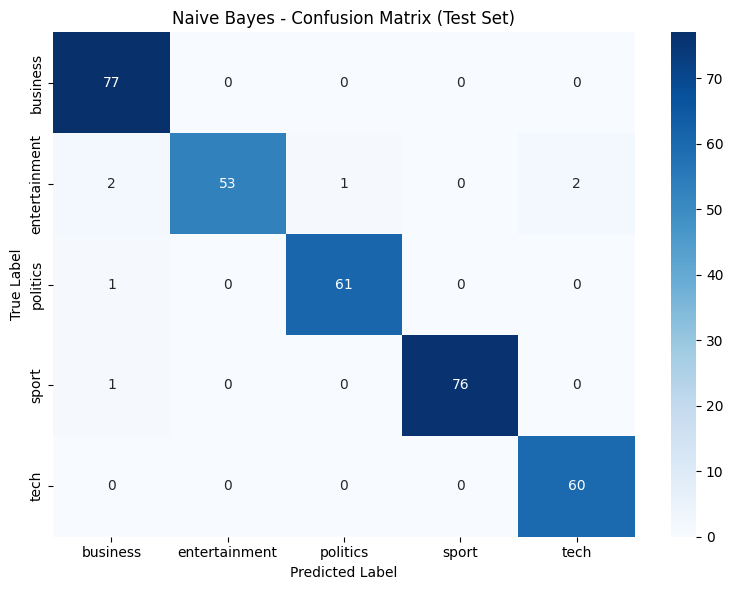


TOP 10 PREDICTIVE WORDS PER CATEGORY

>> BUSINESS
  bn              (log-prob: -5.890)
  said            (log-prob: -6.038)
  growth          (log-prob: -6.304)
  economy         (log-prob: -6.418)
  bank            (log-prob: -6.453)
  oil             (log-prob: -6.481)
  year            (log-prob: -6.487)
  sales           (log-prob: -6.537)

>> ENTERTAINMENT
  film            (log-prob: -5.621)
  best            (log-prob: -6.288)
  said            (log-prob: -6.512)
  music           (log-prob: -6.520)
  star            (log-prob: -6.588)
  awards          (log-prob: -6.627)
  festival        (log-prob: -6.674)
  album           (log-prob: -6.681)

>> POLITICS
  mr              (log-prob: -5.631)
  said            (log-prob: -5.919)
  labour          (log-prob: -6.160)
  election        (log-prob: -6.177)
  blair           (log-prob: -6.227)
  party           (log-prob: -6.352)
  government      (log-prob: -6.388)
  brown           (log-prob: -6.559)

>> SPORT
  game            (l

In [1]:
# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2. LOAD DATA ---
df = pd.read_csv('bbc_data.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nLabel distribution:")
print(df['labels'].value_counts())

# --- 3. TEXT PREPROCESSING FUNCTION ---
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(f'[{string.punctuation}0-9]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['cleaned_text'] = df['data'].apply(clean_text)

print("\nSample cleaned text:")
print(df['cleaned_text'].iloc[0][:200] + "...")

# --- 4. LABEL ENCODING ---
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['labels'])

print("\nLabel mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i} → {label}")

# --- 5. TRAIN/VAL/TEST SPLIT (Stratified) ---
X = df['cleaned_text']
y = df['label_encoded']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"\nSplit sizes:")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- 6. TF-IDF VECTORIZATION ---
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),        # Include bigrams
    stop_words='english',
    min_df=2                  # Ignore very rare words
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print(f"\nTF-IDF Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"X_train_vec shape: {X_train_vec.shape}")

# --- 7. TRAIN NAIVE BAYES MODEL ---
nb_model = MultinomialNB(alpha=1.0)  # Laplace smoothing
nb_model.fit(X_train_vec, y_train)

# --- 8. PREDICTIONS ---
y_val_pred = nb_model.predict(X_val_vec)
y_test_pred = nb_model.predict(X_test_vec)

# --- 9. EVALUATION FUNCTION ---
def evaluate(y_true, y_pred, split_name):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{split_name} Results:")
    print(f"Accuracy : {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

# Evaluate
evaluate(y_val, y_val_pred, "Validation")
evaluate(y_test, y_test_pred, "Test")

# --- 10. CONFUSION MATRIX (Test Set) ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Naive Bayes - Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- 11. FEATURE INSIGHTS: Top words per class ---
def get_top_words(model, vectorizer, class_idx, top_n=10):
    log_prob = model.feature_log_prob_[class_idx]
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_indices = log_prob.argsort()[-top_n:][::-1]
    return [(feature_names[i], log_prob[i]) for i in top_indices]

print("\n" + "="*60)
print("TOP 10 PREDICTIVE WORDS PER CATEGORY")
print("="*60)
for i, label in enumerate(le.classes_):
    print(f"\n>> {label.upper()}")
    top_words = get_top_words(nb_model, vectorizer, i, top_n=8)
    for word, prob in top_words:
        print(f"  {word:<15} (log-prob: {prob:.3f})")

##### Milestone 4: Naive Bayes Text Classifier for BBC News Categorization
    Using the bbc_data.csv dataset (2,225 articles across 5 categories), I built a Multinomial Naive Bayes classifier to predict news category from article text.
    Preprocessing: Lowercased, removed punctuation/numbers, applied TF-IDF with bigrams and 5,000 max features.
    Splitting: Stratified 70/15/15 train/val/test to preserve class balance. As with this weeks assignment the stratification allows us to keep the training amounts equal between each to limit model bias and better training. 
    Model: Multinomial Naive Bayes with Laplace smoothing (alpha=1.0).
    Results:

    Test Accuracy: 97.0%
    F1-scores > 0.95 across all classes
    Top predictive terms (e.g., "film", "album" → entertainment; "phone", "software" → tech)

    This first model is able to accurately predict news article label with an accuracy of 97% and an F-1 scor of 95%

##### In future milestones I think we could add the MLP model to this as well for comparison with the Naive-Bayes, trying a Logistic Regression instead as other models are better suited for these types of analysis, but I read about the Naive-Bayes early on and I still wanted to try it out, and it worked out pretty decently! It does what we wanted for our initial objective for this milestone! Thank you! 